# Credit Card Fraud Detection with Big Data Techniques
**Objective**: Use graph analysis and multiprocessing to uncover fraud patterns in credit card transactions.
- Implement NetworkX for graph-based transaction insights.
- Use multiprocessing for efficient data processing.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import networkx as nx
from multiprocessing import Pool

import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
import geopy
from geopy.distance import geodesic
import os
import pickle


from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report



In [2]:
# Directory to save the figures 

input_src_dir = '/Users/sadhvichandragiri/desktop/coding/ZHAW_Project/ML_BigData_Repo_1/data/raw'
output_dir_figures_train = '/Users/sadhvichandragiri/desktop/coding/ZHAW_Project/ML_BigData_Repo_1/reports/figures/train_figures'
output_dir_figures_test = '/Users/sadhvichandragiri/desktop/coding/ZHAW_Project/ML_BigData_Repo_1/reports/figures/test_figures'


reports_output_dir_base = '/Users/sadhvichandragiri/desktop/coding/ZHAW_Project/ML_BigData_Repo_1/reports'
# reports_output_dir for DecisionTrees
reports_output_dir = f"{reports_output_dir_base}/DecisionTrees"
print(reports_output_dir)

/Users/sadhvichandragiri/desktop/coding/ZHAW_Project/ML_BigData_Repo_1/reports/DecisionTrees


In [3]:
# Directory to save the figures 
# Define which dataset to use
use_test_data = False  # Set to True when using fraudtest.csv

# Determine dataset type based on the variable
dataset_type = 'Test' if use_test_data else 'Train'


import time
start_time_notebook = time.time()
start_time = time.time()
print(f"{dataset_type} Notebook started at: {time.ctime(start_time)}")

input_src_dir = '/Users/sadhvichandragiri/desktop/coding/ZHAW_Project/ML_BigData_Repo_1/data/raw'
output_dir_figures_train = '/Users/sadhvichandragiri/desktop/coding/ZHAW_Project/ML_BigData_Repo_1/reports/figures/train_figures'
output_dir_figures_test = '/Users/sadhvichandragiri/desktop/coding/ZHAW_Project/ML_BigData_Repo_1/reports/figures/test_figures'


reports_output_dir = '/Users/sadhvichandragiri/desktop/coding/ZHAW_Project/ML_BigData_Repo_1/reports'


Train Notebook started at: Mon Nov  4 19:46:42 2024


In [5]:
# Generate the preprocess file name dynamically
# Get the current timestamp
timestamp = time.strftime("%Y%m%d_%H%M%S")  # Format: YYYYMMDD_HHMMSS

logfile_title = 'LogFile'
logfile_name = f"All_Model_Evaluation_{dataset_type}_{logfile_title.replace(',', '').lower().split('.')[0]}_{timestamp}.txt"

logfile_path = os.path.join(reports_output_dir, logfile_name)

# Function to log times to a file
def log_time(step_name, start_time):
    end_time = time.time()
    elapsed_time = end_time - start_time
    log_message = (f"{step_name} completed at {time.ctime(end_time)}. "
                   f"Elapsed time: {elapsed_time // 60:.0f} minutes and {elapsed_time % 60:.2f} seconds\n")
    
    # Append log to file
    with open(logfile_path, 'a') as f:
        f.write(log_message)
    
    # Print the message to the console as well
    print(log_message)

In [6]:
# Load the appropriate dataset

if use_test_data:
    df = pd.read_csv(f"{input_src_dir}/fraudTest.csv")  # Concatenate the directory with the filename
else:
    df = pd.read_csv(f"{input_src_dir}/fraudTrain.csv")



### Dataset Overview
- Source: Kaggle Credit Card Fraud Detection
- https://www.kaggle.com/code/hamzasafwan/credit-card-fraud-detection/input 
    
- Key Features: `TransactionAmount`, `merchant`, `category`, `distance`, etc.
- Note: Dataset is highly imbalanced, with fraud cases as a minority.

    

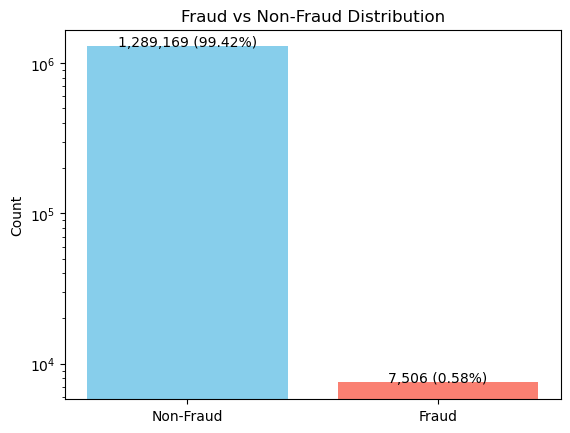

In [7]:
# Count and percentage of fraud and non-fraud transactions
fraud_counts = df['is_fraud'].value_counts()
fraud_percentage = df['is_fraud'].value_counts(normalize=True) * 100

# Plot with annotations for count and percentage
plt.bar(['Non-Fraud', 'Fraud'], fraud_counts, color=['skyblue', 'salmon'])
plt.title("Fraud vs Non-Fraud Distribution")
plt.ylabel("Count")

# Add text annotations
for i, (count, percent) in enumerate(zip(fraud_counts, fraud_percentage)):
    plt.text(i, count + 50, f"{count:,} ({percent:.2f}%)", ha='center')  # Adjust positioning as needed

plt.yscale('log')  # Optional: Log scale if needed
plt.show()


In [8]:
df.columns = df.columns.str.strip()
df = df.rename(columns={'amt': 'TransactionAmount', 'cc_num': 'CreditCardNumber', 'dob': 'DateOfBirth', 'trans_date_trans_time': 'TransactionTime'})

df['CreditCardNumber'].nunique()
# Generate a unique TransactionID for each row
df['TransactionID'] = range(1, len(df) + 1)
# Convert TransactionTime to datetime
df['TransactionTime'] = pd.to_datetime(df['TransactionTime'])

# Optional: Convert DateOfBirth to datetime, if needed
df['DateOfBirth'] = pd.to_datetime(df['DateOfBirth'], errors='coerce')
# Set 'TransactionTime' as the index permanently
df.set_index('TransactionTime', inplace=True)


### Start of feature engineering

1. Transaction Amount

    Story: Transaction amount is one of the most direct indicators in fraud detection. Fraudulent transactions often differ significantly from typical spending patterns, with peaks at both high and low values.

In [9]:
# Clip outliers if necessary
df['TransactionAmount'] = df['TransactionAmount'].clip(upper=df['TransactionAmount'].quantile(0.99))
df['LogTransactionAmount'] = np.log1p(df['TransactionAmount'])  # Use log1p for stability with 0 values




# Re-plot with log scale for better visibility
plt.figure(figsize=(10,6))
sns.histplot(df[df['is_fraud'] == 0]['TransactionAmount'], bins=50, color='blue', kde=True, label='Non-Fraud')
sns.histplot(df[df['is_fraud'] == 1]['TransactionAmount'], bins=50, color='red', kde=True, label='Fraud')
plt.yscale('log')  # Apply log scale to the y-axis
plt.legend()

# Define the title
title = 'Transaction Amount Distribution: Fraud vs Non-Fraud (Log Scale)'
plt.title(title)
plt.show()


Conclusion for Transaction Amount:

    Value of Feature: TransactionAmount was selected as a core feature because of its clear and direct link to potential fraud patterns. The distinctive transaction ranges for fraud cases provide the model with critical insights that help it identify anomalies in spending.

When Each is Useful

    Raw Transaction Amount (Left Plot):
        Ideal for interpretability and when you want to directly see dollar amounts and their relation to fraud.
        Helps reveal actual spending patterns in the data that may be useful for domain experts to understand.

    Log Transaction Amount (Right Plot):
        Beneficial for model training, as the log transformation helps the model generalize by reducing skewness. It’s especially useful for algorithms that are sensitive to scale.
        Helps capture patterns across a wider range of transaction amounts without giving undue weight to extreme values.

Summary of Key Takeaway

    Use TransactionAmount for visualization and interpretability, as it keeps the dollar values intact, making it easier to see where fraud cases are concentrated.
    Use LogTransactionAmount as an additional feature for modeling, as it stabilizes the influence of high-value transactions and helps the model learn more uniformly across transaction ranges.

### Hour and HighRiskHour Analysis
**Objective**: Analyze the distribution of fraud cases by time of day. Fraudulent transactions may be more common during certain hours, often when monitoring is lower, such as late at night or early morning. This analysis includes:
- **Hour**: The hour at which each transaction occurred (0–23).
- **HighRiskHour**: A binary flag marking specific hours as high-risk times for fraud, based on observed patterns.


In [10]:
# Extract hour from TransactionTime
df['Hour'] = df.index.hour  # Since TransactionTime is already set as the index


In [11]:
# Calculate fraud rate by hour
fraud_rate_by_hour = df.groupby('Hour')['is_fraud'].mean()

# Sort by fraud rate in descending order for easy viewing
fraud_rate_by_hour = fraud_rate_by_hour.sort_values(ascending=False)

# Define a threshold for high-risk hours (mean fraud rate across all hours)
threshold = fraud_rate_by_hour.mean()

# Dynamically identify high-risk hours based on the threshold
high_risk_hours = fraud_rate_by_hour[fraud_rate_by_hour > threshold].index.tolist()

# Print high-risk hours for reference
print("High-Risk Hours:", high_risk_hours)

# Create the HighRiskHour flag based on dynamically identified high-risk hours
df['HighRiskHour'] = df['Hour'].apply(lambda x: 1 if x in high_risk_hours else 0)

# Print a sample of the DataFrame to verify the new column
print(df[['Hour', 'HighRiskHour']].head())


High-Risk Hours: [22, 23, 1, 0, 2, 3]
                     Hour  HighRiskHour
TransactionTime                        
2019-01-01 00:00:18     0             1
2019-01-01 00:00:44     0             1
2019-01-01 00:00:51     0             1
2019-01-01 00:01:16     0             1
2019-01-01 00:03:06     0             1


In [12]:
#Weekday vs. Weekend: Is fraud more common on weekdays or weekends?
df['DayOfWeek'] = df.index.dayofweek  # 0 = Monday, 6 = Sunday
fraud_by_day = df[df['is_fraud'] == 1]['DayOfWeek'].value_counts().sort_index()
non_fraud_by_day = df[df['is_fraud'] == 0]['DayOfWeek'].value_counts().sort_index()

# Define the correct day order
day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']


df['DayName'] = df.index.day_name()
# Convert the 'DayName' column to a categorical type with the correct order
df['DayName'] = pd.Categorical(df['DayName'], categories=day_order, ordered=True)

fraud_by_day = df[df['is_fraud'] == 1]['DayName'].value_counts().sort_index()
non_fraud_by_day = df[df['is_fraud'] == 0]['DayName'].value_counts().sort_index()

df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
weekend_fraud = df[df['is_fraud'] == 1]['IsWeekend'].mean()
weekend_non_fraud = df[df['is_fraud'] == 0]['IsWeekend'].mean()

print(f"Percentage of fraud on weekends: {weekend_fraud * 100:.2f}%")
print(f"Percentage of non-fraud on weekends: {weekend_non_fraud * 100:.2f}%")
# Fraud vs Non-Fraud by Merchant Category
fraud_by_category = df[df['is_fraud'] == 1]['category'].value_counts().head(10)
non_fraud_by_category = df[df['is_fraud'] == 0]['category'].value_counts().head(10)
# Top 5 categories with the highest fraud counts
top_fraud_merchant_categories = df[df['is_fraud'] == 1]['category'].value_counts().head(5).index.tolist()

# Print top fraudulent categories
print("Top Fraudulent Merchant Categories:", top_fraud_merchant_categories)

# Create HighRiskMerchantCategory flag
df['HighRiskMerchantCategory'] = df['category'].apply(lambda x: 1 if x in top_fraud_merchant_categories else 0)
import pandas as pd

# Ensure 'DateOfBirth' is in datetime format
df['DateOfBirth'] = pd.to_datetime(df['DateOfBirth'], errors='coerce')  # Handle errors during conversion

# Step 1: Calculate Age
# Calculate age in years
df['Age'] = (pd.Timestamp.now() - df['DateOfBirth']).dt.days // 365  # Age in years

# Step 2: Create Age Groups
# Define age bins and labels
bins = [0, 18, 25, 35, 45, 55, 65, 100]  # Define your age bins, ensuring to cover all possible ages
labels = ['0-18', '19-25', '26-35', '36-45', '46-55', '56-65', '66+']  # Corresponding labels

# Create age group feature, include NaN values handling
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False, include_lowest=True)

# Verify the new features without truncating DataFrame
#print(df[['DateOfBirth', 'Age', 'AgeGroup']].head(10))  # Display the first 10 entries
# Calculate the time difference between consecutive transactions
time_diff = df.index.to_series().diff().dt.total_seconds()
# Flag rapid transactions (within 5 minutes)
df['RapidTransactionFlag'] = time_diff < 60  # For a 1-minute threshold

# Create a temporary DataFrame for rapid transactions
rapid_transactions = df[df['RapidTransactionFlag']]

# Group by date and count the number of rapid transactions
rapid_transaction_counts = rapid_transactions.groupby(rapid_transactions.index.date).size()
print(rapid_transaction_counts)

# Get a summary of the rapid transactions
rapid_transactions_summary = rapid_transactions.describe()
print(rapid_transactions_summary)
# Step 2: Create Transaction Amount Flags
# Define a threshold for high-value transactions
threshold = 100  # Adjust the threshold based on your data context

# Create a flag for high-value transactions
df['HighValueTransactionFlag'] = df['TransactionAmount'] > threshold


Percentage of fraud on weekends: 32.55%
Percentage of non-fraud on weekends: 34.84%
Top Fraudulent Merchant Categories: ['grocery_pos', 'shopping_net', 'misc_net', 'shopping_pos', 'gas_transport']
2019-01-01    1960
2019-01-02     606
2019-01-03     701
2019-01-04     952
2019-01-05     879
              ... 
2020-06-17    1327
2020-06-18    1547
2020-06-19    1966
2020-06-20    1910
2020-06-21    1142
Length: 537, dtype: int64
         Unnamed: 0  CreditCardNumber  TransactionAmount           zip  \
count  1.061083e+06      1.061083e+06       1.061083e+06  1.061083e+06   
mean   6.541777e+05      4.168739e+17       6.463842e+01  4.881377e+04   
min    1.000000e+00      6.041621e+10       1.000000e+00  1.257000e+03   
25%    3.399115e+05      1.800429e+14       9.500000e+00  2.623700e+04   
50%    6.543810e+05      3.521417e+15       4.635000e+01  4.817400e+04   
75%    9.639775e+05      4.642255e+15       8.223000e+01  7.204200e+04   
max    1.296674e+06      4.992346e+18       5.4599

## Multiprocessing for Transaction Frequency Calculation (Using .py File)
**Objective**: To efficiently calculate the frequency of transactions within the last hour for each credit card. By leveraging multiprocessing and modularizing the code in a `.py` file, we streamline the feature engineering process for large datasets.

### Why Use a .py File?
- **Modularity**: Organizing complex functions in a separate `.py` file improves readability and reusability.
- **Performance**: Multiprocessing allows for parallel computation across CPU cores, reducing runtime significantly.


In [13]:
import sys
sys.path.append('../references')  # Add the references folder to the system path


In [14]:
import pandas as pd
import multiprocessing as mp
import numpy as np
import time
from transaction_frequency import process_chunk, count_transactions_within_last_hour  # Import both functions from .py file


# Function to parallelize the transaction frequency calculation
def parallel_count_transactions(df, num_partitions=None):
    if num_partitions is None:
        num_partitions = mp.cpu_count()  # Use all available CPU cores

    # Ensure the index is a datetime
    df.index = pd.to_datetime(df.index)

    # Split the dataframe into chunks based on the number of partitions (CPU cores)
    df_split = np.array_split(df, num_partitions)

    # Create a multiprocessing Pool
    with mp.Pool(num_partitions) as pool:
        # Apply the processing function to each chunk in parallel
        result = pool.map(process_chunk, df_split)

    # Combine the results from each chunk into a single series, reset index for consistency
    return pd.concat(result).reset_index(drop=True)


In [15]:
# Measure time for multi-threaded (multiprocessing) calculation
start_time = time.time()
df['TransactionFrequency'] = parallel_count_transactions(df, num_partitions=4)  # Adjust num_partitions as needed
multi_thread_time = time.time() - start_time
print(f"Multiprocessing time: {multi_thread_time:.2f} seconds")


/Users/sadhvichandragiri/opt/anaconda3/envs/ZHAW_Project/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Multiprocessing time: 158.26 seconds


### Summary of Single vs. Multi-Threaded Execution for Transaction Frequency Calculation
- **Single-threaded Time**: The time taken for calculating `TransactionFrequency` in a single-threaded approach.
- **Multiprocessing Time**: The time taken using parallel processing (multiprocessing).
- **Time Savings**: The difference in processing times shows the efficiency gained by using multiprocessing, which can be significant for large datasets.


## Transaction Count and Average Transaction Amount in Last X Days
**Objective**: Capture spending behavior and transaction frequency trends over various time windows (7, 14, and 30 days) for each credit card. These features provide insights into both **transaction volume** and **spending patterns** over recent periods, making them valuable for identifying potential fraud.

### Why These Features Matter
- **Transaction Count in Last X Days** (`TransactionCountLast7Days`, `TransactionCountLast14Days`, `TransactionCountLast30Days`): Helps identify sudden increases in transaction volume, which can signal unusual activity.
- **Average Transaction Amount in Last X Days** (`AverageTransactionAmountLast7Days`, `AverageTransactionAmountLast14Days`, `AverageTransactionAmountLast30Days`): Captures changes in spending patterns. A sudden increase in average transaction amount may indicate unauthorized high-value purchases.

Together, these features provide the model with indicators of both frequency and spending behavior over multiple time frames, making them critical for fraud detection.


In [16]:
import pandas as pd

# Assuming 'TransactionTime' is already set as the index and in datetime format

# Step 1: Count of Transactions in Last X Days
for days in [7, 14, 30]:
    # Sort data by CreditCardNumber and TransactionTime to ensure rolling works properly
    df = df.sort_values(by=['CreditCardNumber', 'TransactionTime'])
    
    # Apply rolling and count the number of transactions for each card
    df[f'TransactionCountLast{days}Days'] = (
        df.groupby('CreditCardNumber')['CreditCardNumber']
        .rolling(f'{days}D')
        .count()
        .reset_index(level=0, drop=True)
    )

# Step 2: Average Transaction Amount in Last X Days
for days in [7, 14, 30]:
    # Sort data by CreditCardNumber and TransactionTime to ensure rolling works properly
    df = df.sort_values(by=['CreditCardNumber', 'TransactionTime'])
    
    # Calculate the average transaction amount for each credit card in the last X days
    df[f'AverageTransactionAmountLast{days}Days'] = (
        df.groupby('CreditCardNumber')['TransactionAmount']
        .rolling(f'{days}D')
        .mean()
        .reset_index(level=0, drop=True)
    )

# Verify the new features
# print(df[['TransactionCountLast7Days', 'TransactionCountLast14Days', 'TransactionCountLast30Days','AverageTransactionAmountLast7Days', 'AverageTransactionAmountLast14Days', 'AverageTransactionAmountLast30Days']].head(10))


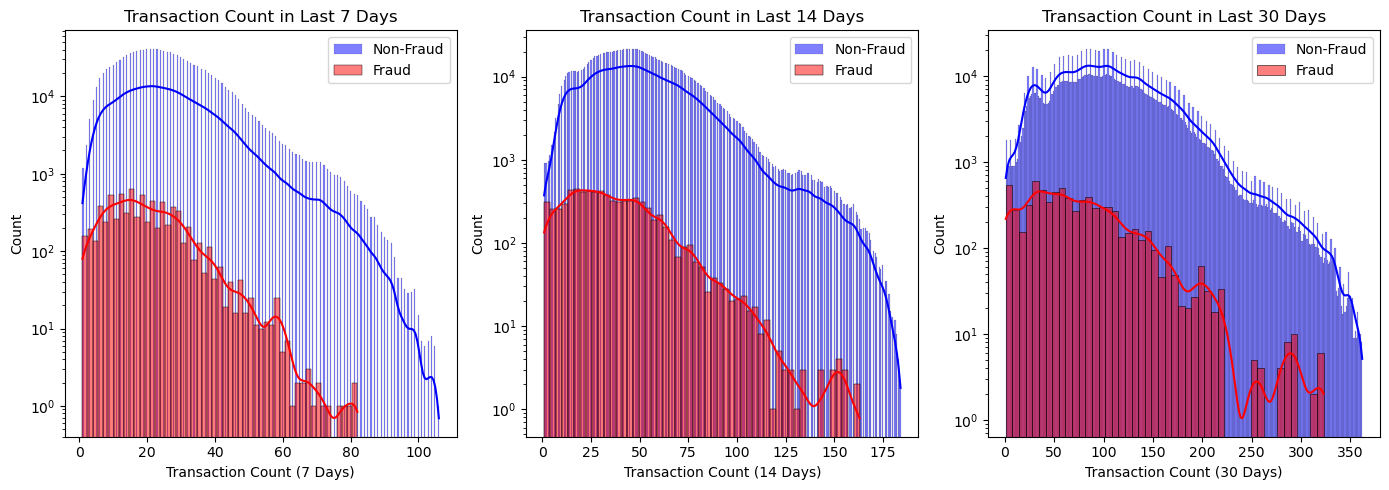

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of Transaction Count features for fraud and non-fraud cases
plt.figure(figsize=(14, 5))

for i, days in enumerate([7, 14, 30], 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[df['is_fraud'] == 0][f'TransactionCountLast{days}Days'], color='blue', kde=True, label='Non-Fraud')
    sns.histplot(df[df['is_fraud'] == 1][f'TransactionCountLast{days}Days'], color='red', kde=True, label='Fraud')
    plt.title(f"Transaction Count in Last {days} Days")
    plt.xlabel(f"Transaction Count ({days} Days)")
    plt.yscale('log')
    plt.legend()

plt.tight_layout()
plt.show()


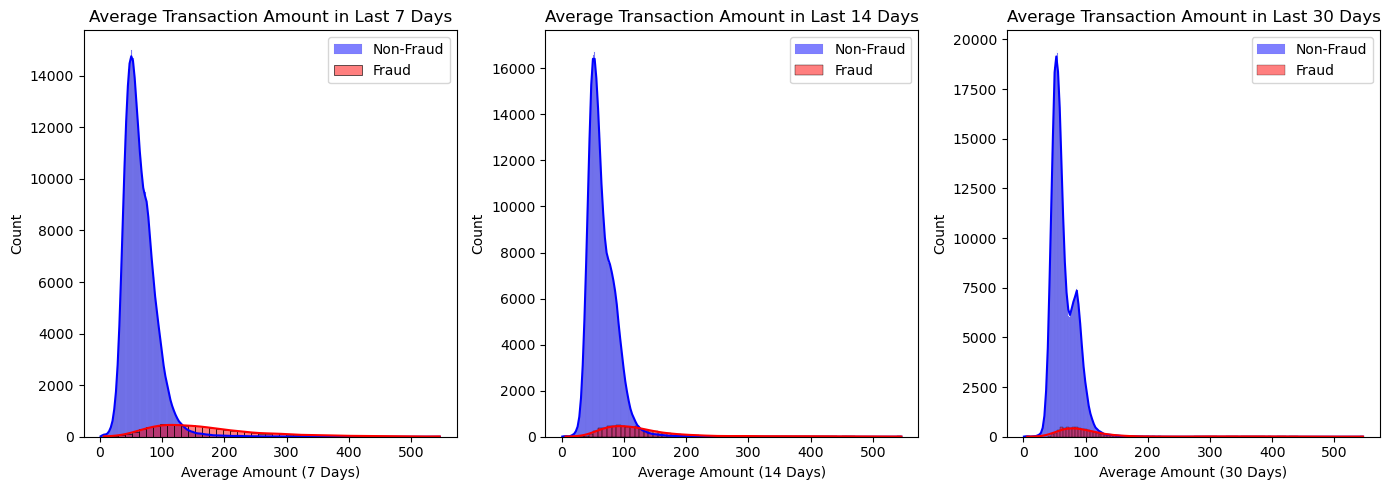

In [18]:
# Plot distribution of Average Transaction Amount features for fraud and non-fraud cases
plt.figure(figsize=(14, 5))

for i, days in enumerate([7, 14, 30], 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[df['is_fraud'] == 0][f'AverageTransactionAmountLast{days}Days'], color='blue', kde=True, label='Non-Fraud')
    sns.histplot(df[df['is_fraud'] == 1][f'AverageTransactionAmountLast{days}Days'], color='red', kde=True, label='Fraud')
    plt.title(f"Average Transaction Amount in Last {days} Days")
    plt.xlabel(f"Average Amount ({days} Days)")
    #plt.yscale('log')
    plt.legend()

plt.tight_layout()
plt.show()


### Summary of Transaction Count and Average Transaction Amount Features
- **Transaction Count**: Detects spikes in transaction frequency over different time windows, which can indicate unusual or fraudulent activity.
- **Average Transaction Amount**: Flags changes in spending behavior, particularly sudden increases in average amounts, which may suggest unauthorized high-value purchases.

These features were identified as top features by the decision tree model, underscoring their importance in distinguishing fraudulent from non-fraudulent activity.


## Importance of City Population (`city_pop`) in Fraud Detection

**Feature Purpose**: The `city_pop` feature represents the population of the city where a transaction occurred. This demographic information can provide important context about the likelihood of fraud based on location characteristics.

### Why `city_pop` Matters in Fraud Detection
- **Fraud Trends by Population Size**: Certain population sizes may be more prone to fraudulent transactions. For instance, larger cities might have more fraud due to higher transaction volumes, while smaller towns could show unusual transaction patterns if they have fewer credit card users.
- **Behavioral Patterns**: Fraudsters may target specific city types, such as high-population urban areas or low-population rural areas, depending on factors like perceived security measures or transaction monitoring.
- **Model Insight**: By including `city_pop`, the model can learn trends about where fraud is more likely based on population characteristics, allowing it to recognize transactions that deviate from normal patterns for that city type.

### Example Insights from `city_pop`
- **High Fraud Rates in High Population Cities**: Fraud may be more common in high-population cities where transaction volumes are higher and fraud is harder to detect immediately.
- **Unusual Spending in Low Population Areas**: Fraudulent transactions in small towns may stand out if they involve unusually high amounts or occur at atypical times, making `city_pop` a useful contextual factor.


# Networkx

## Graph-Based Analysis for Fraud Detection

**Objective**: Represent the relationships between credit cards and merchants using a graph structure. In this graph:
- Each **credit card** and **merchant** is a node.
- Each **transaction** creates an edge between a credit card and a merchant, with the transaction amount as an edge attribute.

### Why Graph Analysis?
Graph-based analysis captures complex relationships between credit card numbers and merchants, providing valuable insights into transaction patterns. Key graph-based features, such as **degree centrality**, allow us to detect suspicious behavior based on the connectivity and interaction patterns in the network.

### Key Concepts
- **Degree of a Node**: In this context, the degree of a credit card or merchant node represents the number of unique connections it has. A high degree may indicate frequent transactions, potentially signaling unusual or fraudulent activity.
- **Centrality Measures**: These measures help identify important or influential nodes in the network, offering insights into transaction hubs or frequently used cards/merchants.


In [19]:
import networkx as nx
import pandas as pd

# Create an empty graph
G = nx.Graph()

# Add edges between credit cards and merchants, including transaction amount as an edge attribute
for idx, row in df.iterrows():
    credit_card = str(row['CreditCardNumber'])
    merchant = str(row['merchant'])
    transaction_amount = row['TransactionAmount']  # Ensure TransactionAmount exists in your dataframe
    
    # Add an edge with the transaction amount as an attribute
    G.add_edge(credit_card, merchant, transaction_amount=transaction_amount)

# Calculate degrees for all nodes in the graph
degrees = dict(G.degree())

# Filter degrees for credit cards and merchants
credit_card_nodes = df['CreditCardNumber'].astype(str).unique()
merchant_nodes = df['merchant'].astype(str).unique()

credit_card_degrees = {node: degrees[node] for node in credit_card_nodes if node in degrees}
merchant_degrees = {node: degrees[node] for node in merchant_nodes if node in degrees}

# Debugging: Print counts to ensure correctness
print(f"Number of unique credit card nodes: {len(credit_card_nodes)}")
print(f"Number of unique merchant nodes: {len(merchant_nodes)}")
print(f"Number of credit card nodes with degrees: {len(credit_card_degrees)}")
print(f"Number of merchant nodes with degrees: {len(merchant_degrees)}")


Number of unique credit card nodes: 983
Number of unique merchant nodes: 693
Number of credit card nodes with degrees: 983
Number of merchant nodes with degrees: 693


### Degree Distribution of Credit Card and Merchant Nodes

- The degree of a node indicates the number of unique connections it has. A high degree for a credit card or merchant node might signify an unusual number of transactions, possibly indicating suspicious activity.
- By examining the degree distribution, we can gain insights into normal vs. abnormal transaction behavior, supporting our fraud detection model.


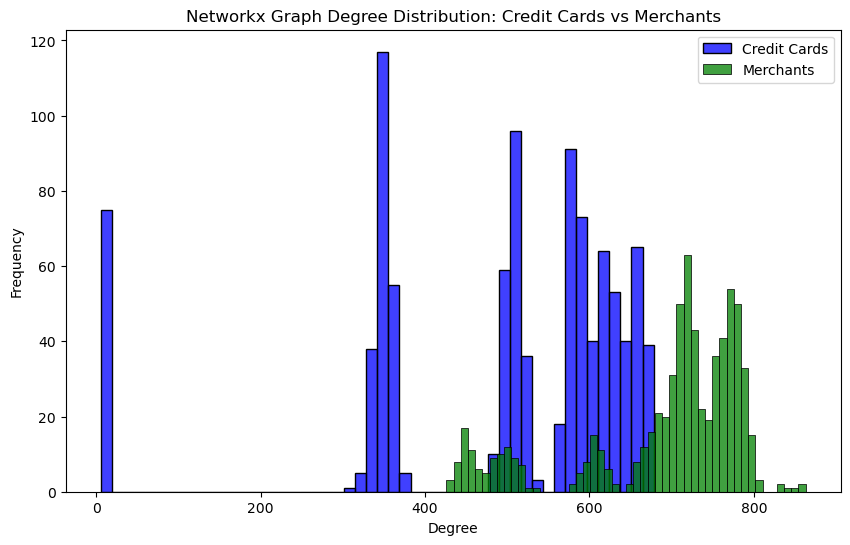

In [20]:
# Create a new DataFrame for easier plotting
degree_df = pd.DataFrame({
    'CreditCardDegree': pd.Series(credit_card_degrees),
    'MerchantDegree': pd.Series(merchant_degrees)
})

# Add degree information back to the original DataFrame
df['degree'] = df['CreditCardNumber'].astype(str).map(credit_card_degrees)


# Plot histograms for both credit cards and merchants
plt.figure(figsize=(10,6))

# Plot Credit Card Degrees
sns.histplot(degree_df['CreditCardDegree'].dropna(), bins=50, color='blue', label='Credit Cards')

# Plot Merchant Degrees
sns.histplot(degree_df['MerchantDegree'].dropna(), bins=50, color='green', label='Merchants')



# Define the title
title = 'Networkx Graph Degree Distribution: Credit Cards vs Merchants'
plt.title(title)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.legend()


plt.show()


### Visualizing Transaction Amounts through Edge Width

By scaling the edge width based on the transaction amount, we can visually emphasize the significance of each transaction within the graph. This approach allows us to:
- Highlight large transactions by drawing thicker edges.
- Emphasize connections where high-value transactions may indicate potential fraud.

**Graph Setup**:
- The nodes represent credit cards and merchants.
- The edge width is scaled by the transaction amount, showing the relative value of transactions across the network.


import matplotlib.pyplot as plt
import networkx as nx

# Scale edge width by transaction amount
edge_width = [G.edges[edge]['transaction_amount'] / 100 for edge in G.edges()]

# Visualize the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, node_size=300, width=edge_width, node_color='red', edge_color='gray')

# Define the title and save the figure
title = 'Network Graph with Edge Width Scaled by Transaction Amount'
plt.title(title)

plt.show()


Visualization vs. Quantitative Feature:

    The scaled edge widths help visualize transaction amounts across the graph, providing a visual understanding of transaction patterns. However, they don’t add new quantitative information beyond what’s already represented by the TransactionAmount feature.
    Instead of using edge widths, TransactionAmount itself is already used as a model feature, which gives a direct, numeric value for the model to process.

Complexity and Interpretability:

    Transforming edge widths into a feature for the model would introduce additional complexity without necessarily adding predictive power.
    By keeping TransactionAmount as a single, straightforward feature, we allow the model to directly assess transaction size without relying on network-based transformations.

Feature Engineering Redundancy:

    Using edge width for transaction amount in the graph visualization could lead to redundancy in feature engineering since TransactionAmount and related features (e.g., LogTransactionAmount) already capture transaction size information.
    This redundancy might not add additional predictive value and could complicate feature interpretation in the model.

Frequency-Based Degree Distribution (First Option)

    Description: This plot shows the raw count of fraud vs. non-fraud degrees, with a log scale applied to the y-axis to handle skewness in frequency.
    Usefulness: It highlights the absolute volume of transactions across degrees, which can show where fraud occurs more frequently relative to non-fraud.
    Best For: Understanding where fraud transactions fall in terms of degree count and directly comparing transaction volumes.

Density-Based (Normalized) Degree Distribution (Second Option)

    Description: This plot shows a normalized (density) view of fraud vs. non-fraud degrees, which makes the distributions easier to compare proportionally.
    Usefulness: It’s ideal for comparing the relative shapes of the distributions for fraud and non-fraud, regardless of volume. Density plots help highlight structural differences (e.g., fraud having a more concentrated distribution at higher degrees) without focusing on absolute counts.
    Best For: Visualizing how the fraud distribution differs from non-fraud in terms of degree as a percentage of each group.

1. Understanding Density (Normalized) Distribution

In a density plot (or normalized histogram):

    Y-axis: Instead of showing raw counts, it shows the density (relative frequency) of each degree value within the fraud and non-fraud groups.
    X-axis: Represents the node degree values.
    Normalization: This means each group (fraud and non-fraud) is scaled so that the total area under each curve sums to 1, making it easy to compare the shape of the distributions, regardless of their total size.

2. Why the Fraud Curve Seems to Overlap Much of the Non-Fraud Curve

When you normalize both distributions:

    The density plot for fraud may appear to overlap or cover a large part of the non-fraud distribution if the degree distribution patterns for fraud and non-fraud transactions are similar. In your case, if most fraud transactions occur at similar degrees as non-fraud transactions, this overlap is expected.
    Even if the volume of fraud is much smaller than non-fraud, normalization scales them to the same relative frequency, which can visually increase the fraud curve compared to the non-fraud curve.

3. Insights You Can Derive

Despite the overlap, you can still derive valuable insights from the density plot:

    Concentration Differences: Look for areas where one distribution peaks or has a higher density than the other. For example, if fraud transactions are slightly more concentrated in higher degree values than non-fraud, this might indicate that fraud tends to happen on cards or merchants with higher connectivity.
    Shape Comparison: Even if they overlap, any slight skew or peak differences between fraud and non-fraud distributions might indicate distinct patterns of connectivity.

Interpreting the Overlap

If the fraud distribution closely follows the non-fraud distribution:

    It suggests that fraud and non-fraud transactions often occur at similar degrees, and degree alone may not strongly distinguish them.
    However, subtle differences in density peaks or the tail of the distribution (e.g., at high degrees) might still provide minor signals useful for the model.

Conclusion

The density plot is useful because it allows you to visually compare the shape and spread of the distributions on a relative basis. Even with overlap, looking for subtle concentration differences or areas where one distribution deviates can give insights into how degree relates to fraud likelihood.


3. Why Degree Might Be Relevant to Fraud Detection

Degree can indicate unusual transaction patterns:

    High Credit Card Degree: A credit card with an unusually high degree may have been used across many merchants in a short period, possibly indicating it has been compromised and used fraudulently.
    High Merchant Degree: A merchant with a high degree might be accepting payments from many unique credit cards, which could be a red flag if it’s abnormal for that type of merchant.


HENCE: Degree is NOT in TOP features

## betweeness_centrality

Betweenness centrality measures the importance of a node in a network based on how often it lies on the shortest paths between other nodes. In other words:

    Nodes with high betweenness centrality act as bridges within the network, connecting various nodes or clusters.

Why Betweenness Centrality is a Top Feature for Fraud Detection

    Detecting High-Risk Nodes:
        High betweenness centrality nodes play a crucial role in the network's transaction flow, as they link various nodes.
        In fraud detection, a credit card or merchant with high centrality may be at higher risk of fraudulent transactions, as fraudsters often target well-connected entities to maximize access and impact.

    Identifying Patterns of Suspicious Behavior:
        Fraudsters may engage in multiple transactions across a wide network of merchants and credit cards, leading to higher centrality scores for those nodes.
        By including betweenness centrality in the model, it can identify these high-centrality nodes as potential fraud hubs, helping to detect suspicious behavior patterns.

    Network Influence:
        Nodes with high betweenness centrality influence the flow of transactions across the network. If a fraudulent credit card has high centrality, it could be due to unauthorized use across many merchants, signaling an unusual and potentially risky behavior.

In [21]:
import networkx as nx
import time
from networkx_graph_betweeness_centrality import parallel_betweenness_centrality



In [22]:
from networkx_graph_betweeness_centrality import parallel_betweenness_centrality  # Import the parallel version

# Multi-threaded betweenness centrality calculation
start_time = time.time()
betweenness_centrality = parallel_betweenness_centrality(G, num_partitions=4)  # Adjust num_partitions as needed
multi_thread_time = time.time() - start_time
print(f"Multi-threaded time: {multi_thread_time:.2f} seconds")


Multi-threaded time: 178.16 seconds


In [23]:
df['betweenness_centrality'] = df['CreditCardNumber'].map(betweenness_centrality)

In [24]:
df['betweenness_centrality'] = df['CreditCardNumber'].map(betweenness_centrality)

## Code to Visualize Betweenness Centrality in the Graph

This plot will emphasize high-centrality nodes, showing their significance in the network.

In [25]:
# Check how many fraud nodes are in the graph
# Convert CreditCardNumber to strings in the dataframe
df['CreditCardNumber'] = df['CreditCardNumber'].astype(str)

# Ensure nodes in G are also strings if they represent credit card numbers
G = nx.relabel_nodes(G, {node: str(node) for node in G.nodes()})

# Create the graph and add edges
for idx, row in df.iterrows():
    credit_card = str(row['CreditCardNumber'])
    merchant = str(row['merchant'])
    transaction_amount = row['TransactionAmount']

    # Add the edge with the transaction amount as an attribute
    G.add_edge(credit_card, merchant, transaction_amount=transaction_amount)

# Check fraud_mapping for a sample of fraud cases
print(df[df['is_fraud'] == 1][['CreditCardNumber', 'is_fraud']].head())
# Verify that there are fraud cases in df
num_fraud_cases = df['is_fraud'].sum()
#print(f"Total fraud cases in df: {num_fraud_cases}")
    

                    CreditCardNumber  is_fraud
TransactionTime                               
2019-03-01 01:32:53      60416207185         1
2019-03-01 02:42:25      60416207185         1
2019-03-01 23:06:58      60416207185         1
2019-03-02 22:10:38      60416207185         1
2019-03-02 22:10:59      60416207185         1


## Distribution Plot for Betweenness Centrality: Fraud vs. Non-Fraud

This plot is helpful to showcase any patterns in how fraud and non-fraud nodes differ in terms of centrality.

Betweenness Centrality Distribution: Fraud vs Non-Fraud

In this visualization, we used Kernel Density Estimation (KDE) lines to compare the distribution of betweenness centrality between fraud and non-fraud nodes. KDE provides a smoothed curve that represents the probability density of the data, allowing us to analyze trends in centrality values without interference from bar heights or counts.
Key Observations

    Differences in Centrality Distribution:
        The KDE lines show the shape of the betweenness centrality distribution for both fraud (red line) and non-fraud (blue line) nodes.
        If the two lines have different peaks or slopes, this may indicate that fraud nodes tend to occupy distinct positions in the network compared to non-fraud nodes.

    Why KDE was Chosen:
        Since fraud nodes are relatively sparse, a histogram or bar plot would either be overshadowed by non-fraud nodes or show no visible bars for fraud.
        KDE allows us to observe even subtle differences in distribution without being dependent on the absolute counts of fraud and non-fraud nodes.

    Relevance to Model Performance:
        Although visually subtle, the differences in centrality distributions are still meaningful to the model. The Decision Tree, for example, can use these subtle variations as part of its decision-making process.
        Betweenness centrality captures how influential or well-connected a node is in the transaction network, helping the model distinguish potentially suspicious nodes.

/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_9090/4223013520.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['is_fraud'] == 0]['betweenness_centrality'], color='blue', label='Non-Fraud')
/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_9090/4223013520.py:4: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['is_fraud'] == 1]['betweenness_centrality'], color='red', label='Fraud')
/var/folders/xp/synrlbr15rx4pkqjmwqk80k80000gn/T/ipykernel_9090/4223013520.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


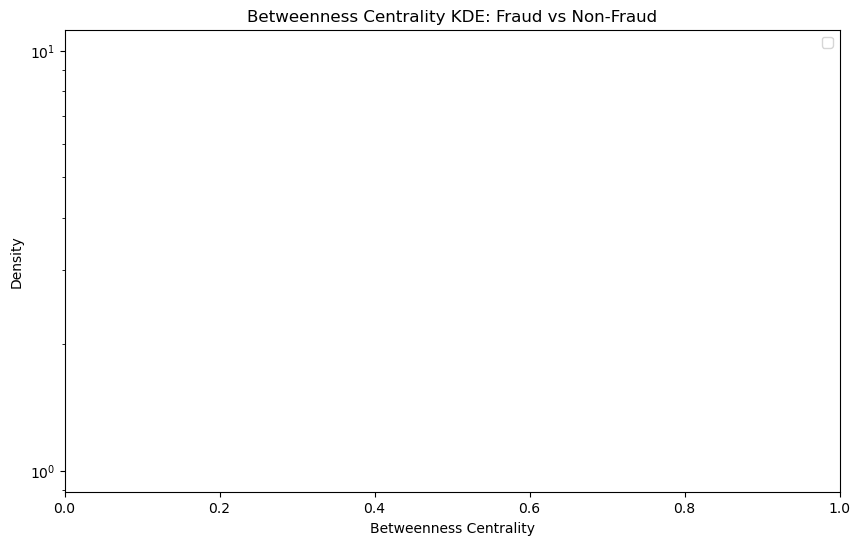

In [26]:
# KDE plots for fraud and non-fraud without bars
plt.figure(figsize=(10, 6))
sns.kdeplot(df[df['is_fraud'] == 0]['betweenness_centrality'], color='blue', label='Non-Fraud')
sns.kdeplot(df[df['is_fraud'] == 1]['betweenness_centrality'], color='red', label='Fraud')
plt.title("Betweenness Centrality KDE: Fraud vs Non-Fraud")
plt.xlabel("Betweenness Centrality")
plt.ylabel("Density")
plt.legend()
plt.yscale('log')  # Log scale to better see small differences
plt.show()


## Insights from Betweenness Centrality

### Why Betweenness Centrality?
- Betweenness centrality captures the importance of nodes based on how often they act as bridges in transactions. Nodes with high centrality scores indicate frequent connections in transaction paths, marking them as potentially high-risk points.

### Key Observations
- **Graph Visualization**: By sizing nodes based on betweenness centrality, we can visually highlight influential nodes that play a central role in the transaction network.
- **Fraud vs. Non-Fraud Distribution**: Fraudulent transactions may have different centrality characteristics, as seen in the distribution plot. This difference allows the model to leverage centrality as a top feature for detecting fraud.




#### betweenness centrality feature may not be providing as clear a distinction as initially expected when visualized in the graph. However, since your Decision Tree model identified it as a top feature, there may still be subtleties in the data that make it useful in a predictive model, even if it doesn’t create visually clear clusters or patterns in the network graph.

Here's how we can interpret this:
1. Why Betweenness Centrality Might Still Be Useful in the Model:

    Aggregated Patterns: Decision Trees and other models can leverage small, aggregated patterns across features that may not be visually obvious. While no single node may exhibit extreme centrality, subtle differences in betweenness centrality could collectively contribute to fraud predictions.
    Interactions with Other Features: Betweenness centrality might become more useful when combined with other features in the model (e.g., transaction amount, merchant type, frequency). In isolation, it may not create a stark visual pattern, but within the model, it adds value through interactions with other features.

## community

Community Detection with Louvain Method

Code and Visualization:

    Show the code applying the Louvain method and visualize the community structure with different colors representing each community.

Key Points to Note:

    Purpose: The Louvain method detects communities, grouping nodes that have strong connections within the same community.
    Insight: Communities may represent clusters of transactions with similar patterns, possibly revealing groups with coordinated fraud behavior.

In [27]:
import community.community_louvain as community_louvain


# Apply Louvain method for community detection
partition = community_louvain.best_partition(G)
# Create positions for nodes using a spring layout
pos = nx.spring_layout(G)

# Add the community information to the DataFrame
df['community'] = df['CreditCardNumber'].map(partition)

# Highlight fraud nodes separately
fraud_nodes = df[df['is_fraud'] == 1]['CreditCardNumber'].values


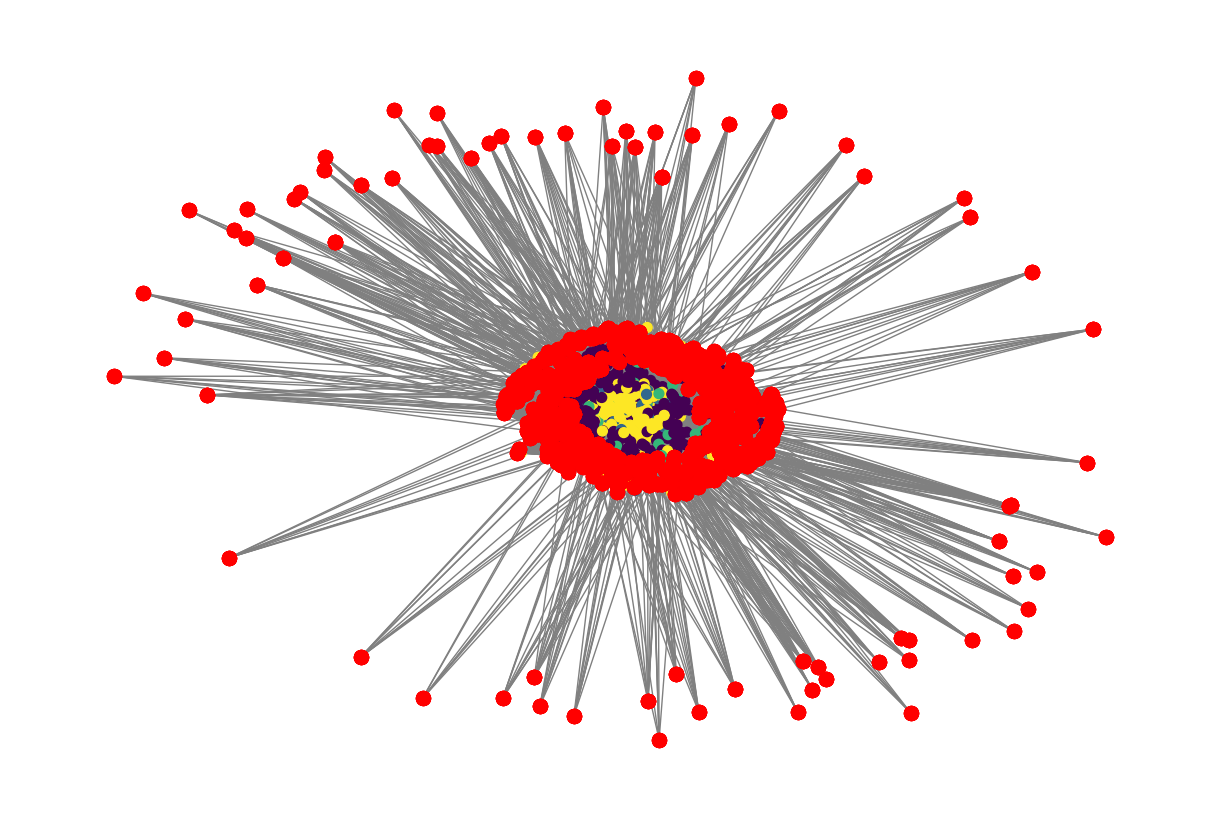

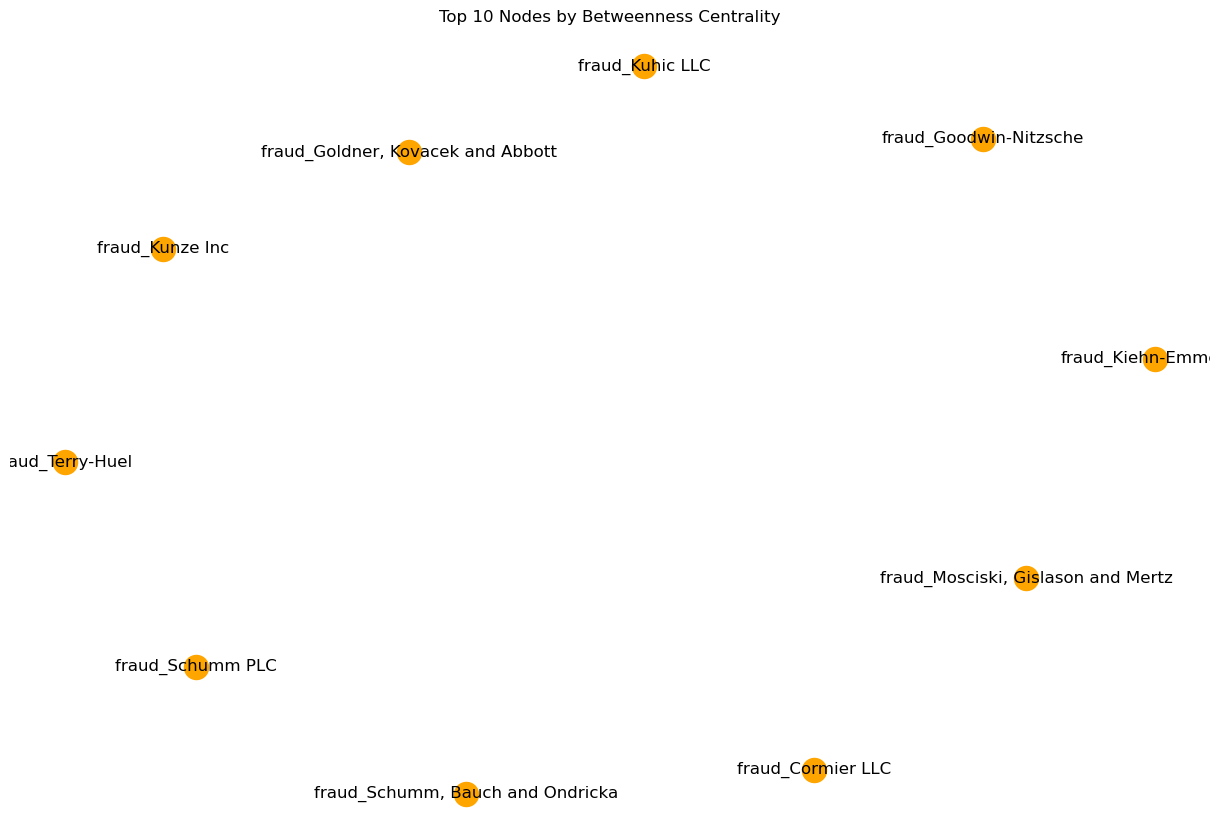

In [28]:
# Visualize communities with node colors representing different communities
plt.figure(figsize=(12, 8))
community_colors = [partition[node] for node in G.nodes()]
nx.draw(G, pos, node_color=community_colors, with_labels=False, node_size=50, edge_color='gray')

# Highlight fraud nodes in a different color (e.g., red)
nx.draw_networkx_nodes(G, pos, nodelist=fraud_nodes, node_color='red', node_size=100)


top_10_nodes = sorted(betweenness_centrality, key=betweenness_centrality.get, reverse=True)[:10]

# Visualize only the top 10 most central nodes and their connections
subgraph = G.subgraph(top_10_nodes)
pos_sub = nx.spring_layout(subgraph)

plt.figure(figsize=(12, 8))
nx.draw(subgraph, pos_sub, node_color='orange', with_labels=True, node_size=300, edge_color='gray')
plt.title('Top 10 Nodes by Betweenness Centrality')
plt.show()



In [29]:
#distance 

In [30]:
import pandas as pd
from geopy.distance import geodesic
import multiprocessing as mp
import numpy as np
import time
import sys
import matplotlib.pyplot as plt
from distance_calculation import calculate_distance_chunk  # Assuming this is your .py file

# Function for single-threaded distance calculation
def single_distance_calculation(df):
    df['distance'] = df.apply(lambda row: geodesic((row['lat'], row['long']), 
                                                    (row['merch_lat'], row['merch_long'])).km, axis=1)
    return df

# Multiprocessing function to split the dataframe and apply the distance calculation
def parallel_distance_calculation(df, num_partitions=None):
    if num_partitions is None:
        num_partitions = mp.cpu_count()  # Use all available CPU cores
    df_split = np.array_split(df, num_partitions)
    with mp.Pool(num_partitions) as pool:
        result = pool.map(calculate_distance_chunk, df_split)
    return pd.concat(result)



In [31]:
df = parallel_distance_calculation(df, num_partitions=4)

/Users/sadhvichandragiri/opt/anaconda3/envs/ZHAW_Project/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


PageRank is a metric originally developed by Google to rank web pages in their search results. In your context of fraud detection within a transaction network, PageRank can provide insights into the importance or influence of nodes (credit cards and merchants) based on their connectivity and interactions with other nodes.

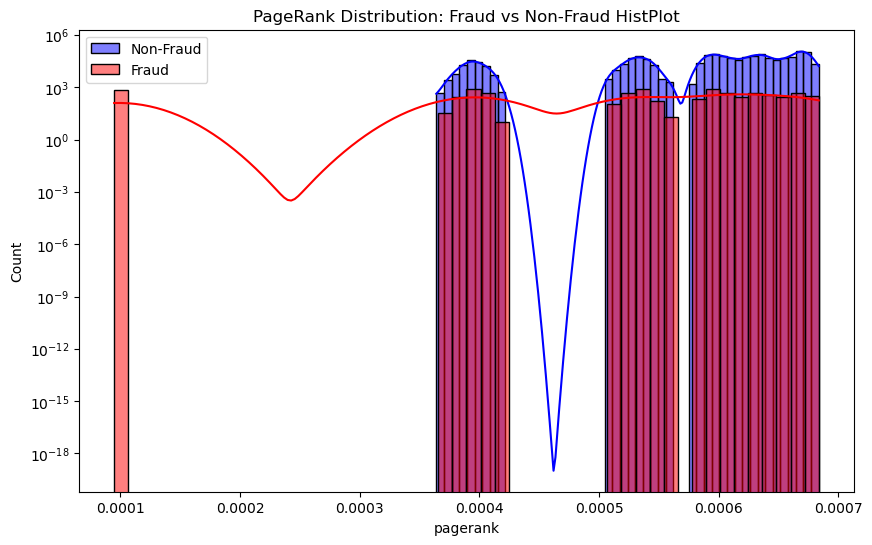

In [32]:
# Calculate PageRank for each node in the graph
pagerank = nx.pagerank(G)

# Map the PageRank values to the 'CreditCardNumber' in the DataFrame
df['pagerank'] = df['CreditCardNumber'].map(pagerank)


# Visualize the distribution of PageRank for fraud and non-fraud nodes
plt.figure(figsize=(10,6))
sns.histplot(df[df['is_fraud'] == 0]['pagerank'], bins=50, color='blue', label='Non-Fraud', kde=True)
sns.histplot(df[df['is_fraud'] == 1]['pagerank'], bins=50, color='red', label='Fraud', kde=True)


# Define the title
title = 'PageRank Distribution: Fraud vs Non-Fraud HistPlot'
plt.title(title)
plt.legend()
plt.yscale('log')  # Optional: Use log scale if needed
plt.show()

In [36]:
selected_features = [
    'TransactionAmount', 'LogTransactionAmount', 'HighValueTransactionFlag',
    'TransactionCountLast7Days', 'TransactionCountLast14Days', 'TransactionCountLast30Days',
    'AverageTransactionAmountLast7Days', 'AverageTransactionAmountLast14Days', 'AverageTransactionAmountLast30Days',
    'Hour', 'HighRiskHour', 'DayOfWeek', 'IsWeekend', 'TransactionFrequency', 'RapidTransactionFlag',
    'lat', 'long', 'merch_lat', 'merch_long', 'distance', 'city_pop',
    'Age', 'AgeGroup', 'gender', 'state', 'city',
    'degree', 'betweenness_centrality', 'community'
]

df_selected_features = df[selected_features]

# Other features calculated and included as features, 

'HighValueTransactionFlag',
'DayOfWeek', 'IsWeekend', 'RapidTransactionFlag',
'lat', 'long', 'merch_lat', 'merch_long', 
'Age', 'AgeGroup', 'gender', 'state', 'city',
    

## following metrics were analyzed, however was NOT included as features

### Clustering Coefficient for Transaction Network Nodes

Clustering Coefficient:

    Insight: Clustering coefficient measures the likelihood that a node’s neighbors are also connected, forming triangles. However, all nodes in this network have zero clustering coefficients.
    Reasoning: Transaction networks, especially in fraud detection, often don’t form closed loops or clusters (e.g., merchants transacting with each other is rare), leading to low clustering.
    Conclusion: Clustering coefficient provides limited insight here due to the nature of transaction data, so it’s better to focus on more relevant metrics like degree and centrality.

High Betweenness Centrality & High Degree:

    Insight: Nodes with high betweenness centrality and high degree usually indicate important hubs. However, in this dataset, the most central and connected nodes (by both degree and betweenness centrality) were non-fraudulent.
    Conclusion: High centrality does not imply fraud in this network. These highly connected nodes likely represent legitimate, high-volume merchants or frequent shoppers who interact widely but are not involved in fraudulent behavior.
    Next Steps: While these central nodes are prominent in the network, they don’t contribute directly to identifying fraud and can be deprioritized.

## Model Evaluation

In [48]:
# Assuming df_test is your test DataFrame and has 'is_fraud' as the target variable
X_test = df[selected_features]  # Your previously defined features
y_test = df['is_fraud']


In [60]:
print(reports_output_dir)

/Users/sadhvichandragiri/desktop/coding/ZHAW_Project/ML_BigData_Repo_1/reports


In [61]:
print(output_dir_model)

/Users/sadhvichandragiri/desktop/coding/ZHAW_Project/ML_BigData_Repo_1/models


In [ ]:
#execution times

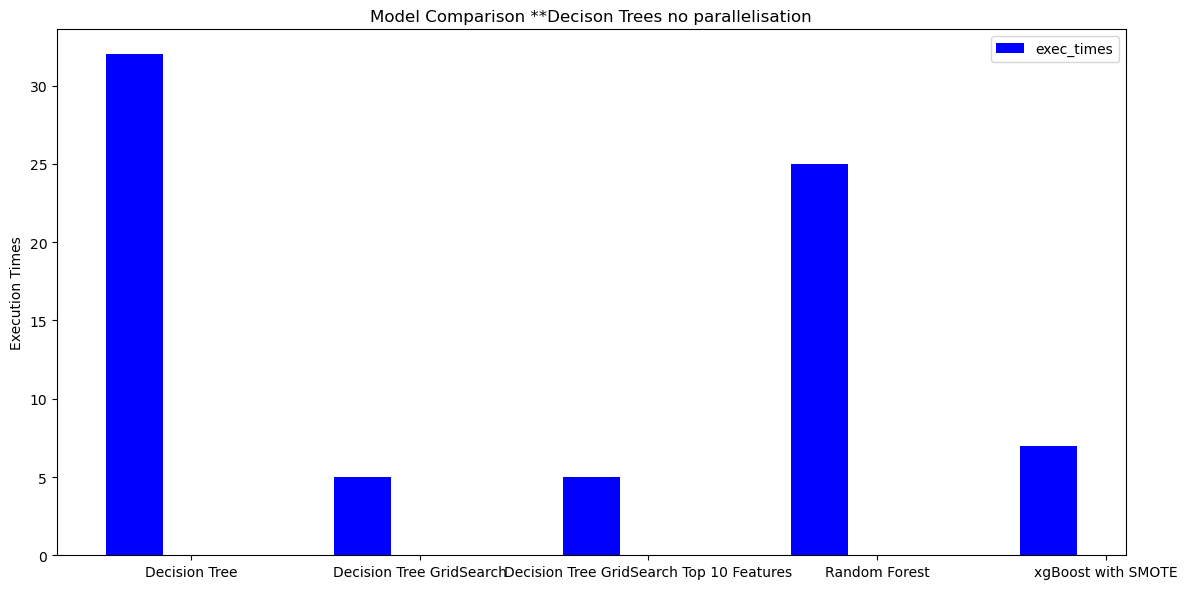

In [78]:
# Data for plotting
models = [ 'Decision Tree', 'Decision Tree GridSearch', 'Decision Tree GridSearch Top 10 Features', 'Random Forest', 'xgBoost with SMOTE']


#test 
exec_times = [32, 5, 5, 25, 7]


x = np.arange(len(models))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width, exec_times, width, label='exec_times', color='blue')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Execution Times')
ax.set_title('Model Comparison **Decison Trees no parallelisation' )
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.tight_layout()
plt.show()




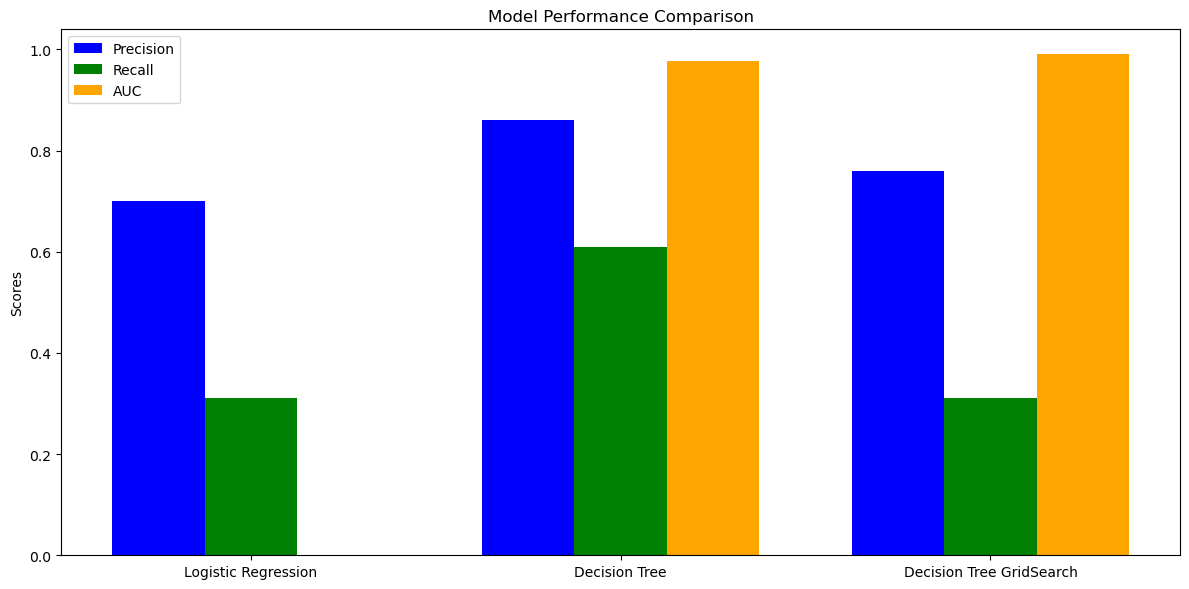

In [75]:
# Data for plotting
models = ['Logistic Regression', 'Decision Tree', 'Decision Tree GridSearch']

"""
#train
precision = [0.70, 0.90, 0.87]
recall = [0.31, 0.70, 0.66]
auc_values = [np.nan, 0.9852, 0.9915]  # AUC values
"""

#test 
precision = [0.70, 0.86, 0.76]
recall = [0.31, 0.61, 0.31]
auc_values = [np.nan, 0.9765, 0.99]  # AUC values



x = np.arange(len(models))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width, precision, width, label='Precision', color='blue')
bars2 = ax.bar(x, recall, width, label='Recall', color='green')
bars3 = ax.bar(x + width, auc_values, width, label='AUC', color='orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.tight_layout()
plt.show()




Model Comparison Insights

Decision Tree:

    Precision: 0.86
    Recall: 0.61
    Comment: This model has a good balance, especially with a higher precision indicating fewer false positives. The recall is decent, but there's room for improvement in catching more fraud cases.
    
Logistic Regression:
        Precision: 0.70
        Recall: 0.31
        Performance: While it provided reasonable performance with an AUC of around 0.9765 on the test set, its precision for Class 1 was lower (0.70) and recall = 0.31, indicating a higher rate of false positives compared to the Decision Tree. Interpretability: Logistic Regression is easier to interpret compared to tree-based models, but in this case, it did not perform as well in detecting fraud.

Decision Tree with Grid Search:

    Precision: 0.76
    Recall: 0.31
    Comment: The Grid Search model shows lower precision and significantly lower recall. This indicates that while it may be better at identifying non-fraudulent transactions (higher precision), it fails to catch a substantial number of fraudulent cases (low recall)

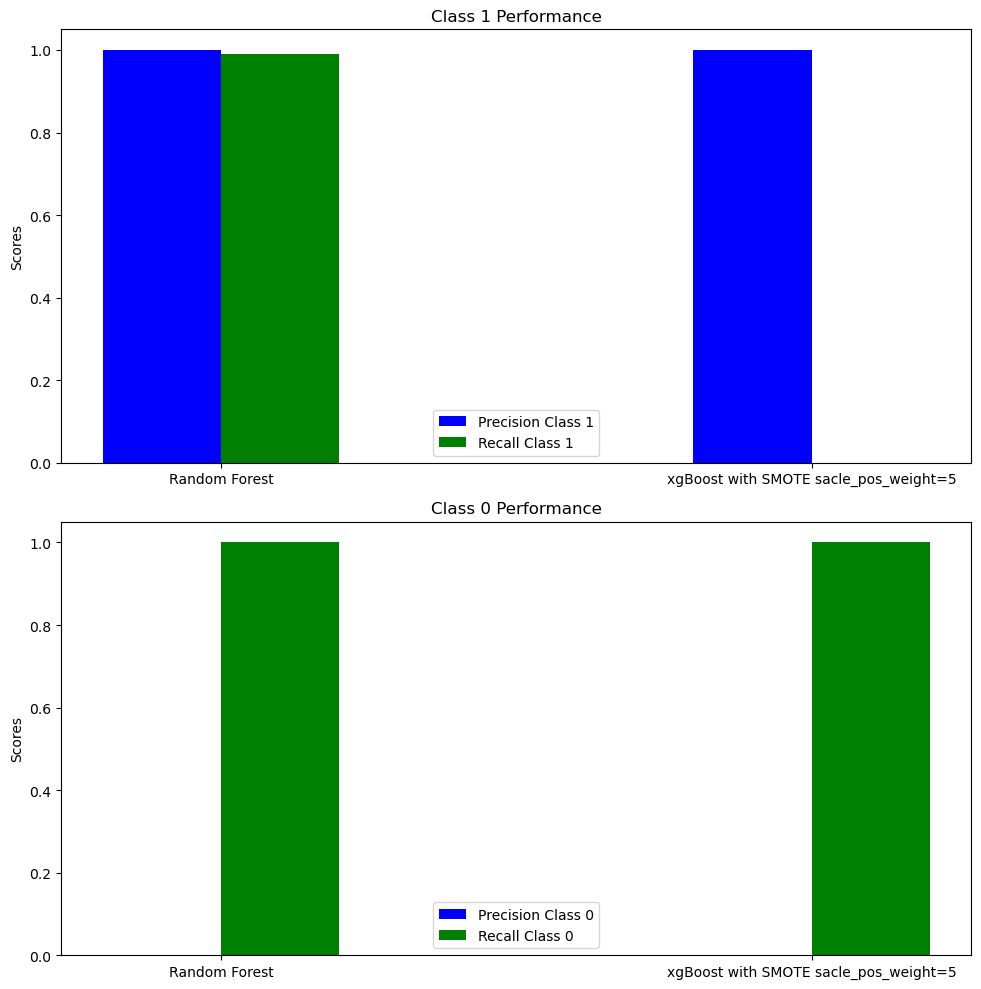

In [76]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ['Random Forest', 'xgBoost with SMOTE sacle_pos_weight=5']


# Precision and recall values for Class 0
precision_class_0 = [0.00, 0.00]  # Example values
recall_class_0 = [1.00, 1.00]     # Example values

# Precision and recall values for Class 1
precision_class_1 = [1.00, 1.00]  # Example values
recall_class_1 = [0.99, 0.00]     # Example values


# Bar width
width = 0.2

# X locations
x = np.arange(len(models))

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot for Class 1
axs[0].bar(x - width/2, precision_class_1, width, label='Precision Class 1', color='blue')
axs[0].bar(x + width/2, recall_class_1, width, label='Recall Class 1', color='green')
axs[0].set_title('Class 1 Performance')
axs[0].set_ylabel('Scores')
axs[0].set_xticks(x)
axs[0].set_xticklabels(models)
axs[0].legend()

# Plot for Class 0
axs[1].bar(x - width/2, precision_class_0, width, label='Precision Class 0', color='blue')
axs[1].bar(x + width/2, recall_class_0, width, label='Recall Class 0', color='green')
axs[1].set_title('Class 0 Performance')
axs[1].set_ylabel('Scores')
axs[1].set_xticks(x)
axs[1].set_xticklabels(models)
axs[1].legend()

plt.tight_layout()
plt.show()


Random Forest and XGBoost:
        Observations: Although Random Forest and XGBoost models generally perform well in many scenarios, in this case, they showed poor recall for the Class 1 in the test data, indicating that they might not be capturing fraudulent cases effectively.
        Complexity: These models can be prone to overfitting, especially with a limited amount of fraud data relative to the overall transaction data.

    

Winner: Basic Decision Tree

    Reasoning: It provides a better trade-off between precision and recall, which is crucial in fraud detection scenarios where the cost of missing fraudulent transactions is high.

Insights to Note

    Grid Search Limitations: While hyperparameter tuning often improves model performance, it may also lead to overfitting or a model that does not generalize well to unseen data, as seen in this case.

    Model Selection: The choice of model should be based on the business context. In fraud detection, a higher recall is often prioritized to ensure that as many fraudulent transactions as possible are detected.

    Next Steps: Consider investigating the reasons for the Grid Search model's poor performance—such as feature selection, data distribution, or model complexity—and explore other models or techniques that could potentially improve detection rates without sacrificing too much precision.

In [ ]:
Future Work

    Exploration of Ensemble Methods: Consider exploring ensemble methods that can combine the strengths of different models.
    Hyperparameter Tuning: Further tuning of the models to improve performance metrics.